# This notebook illustrates:
1. Some Math <br>
2. JUMP software which is leading the world of optimization <br>
3. a slighlty clever use of JUMP software <br>
4. An example of what macros (commands with the @ in front) can really do for us

# Let's look at eigenvalues of positive matrices!

In [2]:
using Plots

In [103]:
n = 5
M = rand(n,n)
λ = eigvals(A)

5-element Array{Complex{Float64},1}:
    2.34466+0.0im     
 -0.0434923+0.150432im
 -0.0434923-0.150432im
  0.0410216+0.0im     
   0.516638+0.0im     

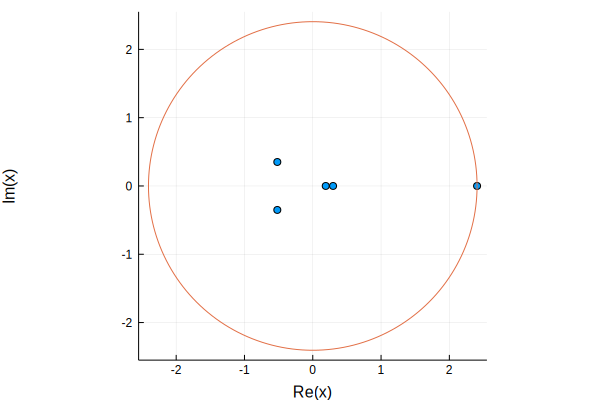

In [132]:
n = 5
M = rand(n,n)
λ = eigvals(M)
gr()
ρ = maximum(abs.(λ))
scatter(λ,label="")
t = 0:.01:2
plot!( ρ*cos.(t*π), ρ*sin.(t*π),aspectratio=1,label="")

The radius of the red circle is known as the [spectral radius](https://en.wikipedia.org/wiki/Spectral_radius) of the matrix.
The circle is the smallest circle centered at the origin in the complex plane that contains all the eigenvalues.

# The Perron Frobenius Theorem

states that a positive matrix (all entries > 0) has exactly one eigenvalue on the red circle, it is positive, real, and the corresponding eigenvector is positive real.  [Wikipedia artcle](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem)

# Proof from Gil Strang's book 

[courtesy of  StackExchange](https://math.stackexchange.com/questions/2823094/perron-frobenius-theorem-proof)

(I suspect that the proof is not often read.)

<img src="https://i.stack.imgur.com/QWfS3.jpg">



One way to form this maximum problem is write this as a constrained optimization:

maximize $t$  subject to   <br>
$x_i \ge 0 $,
$\ \ y=Ax$, 
$\ \ y_i/x_i \ge t$,
$\ \ \sum x_i=1$

# First Paragraph by Julia and JUMP! 
JUMP is a Julia Macro Success Story <br>
Julia for DSL's [Domain Specific Languages](https://en.wikipedia.org/wiki/Domain-specific_language)

In [ ]:
# Pkg.add("JuMP");# Pkg.add("Ipopt")
using JuMP,Ipopt

In [125]:
n=size(A,1)
m = Model(solver=IpoptSolver(print_level=2))
@variable(m, t);         @objective(m, Max, t)
@variable(m, x[1:n]>=0)
@variable(m, y[1:n]);    @constraint(m, y .== A*x)
 
@NLconstraint(m, [i=1:n], t <= y[i]/x[i])  # nonlinear constraint
@constraint(m, sum(x)==1)

status = solve(m)
x = getvalue.(x)
t = getobjectivevalue(m)
println(t)
x

2.9025060522427153


5-element Array{Float64,1}:
 0.2123  
 0.248963
 0.263872
 0.123898
 0.150967

In [126]:
norm(A*x-t*x)

2.6034060828989154e-9

Step #1. Define τ as the minimum of y./x 

In [94]:
# Define τ(y,x) on vectors (assume x and y has positive elements)
τ(y::Vector, x::Vector) = minimum(y./x)

τ (generic function with 1 method)

Exercise: What is τ(Ax,x) when x is an eigenvector?

Notice that for 0 ≤ t ≤ τ(y,x) we have all(y .≥ t*x) <br>
and for t larger than τ this breaks down

In [95]:
# Example: every element of y is at least 2x 
# the corresponding element of x
y = [10,5,6,9]
x = [1, 2,3,4]
τ(y,x)

2.0

In [96]:
all(y.≥2x), all(y.≥1.99x),all(y.≥2.01x)  # check these by hand

(true, true, false)

Step #2. Observe that if all(A.>0) and  all(y.≥0) and y is not the zero vector then all(A*y.>0)  (strictly greater)

In [97]:
# Example
A= [ 1 2 3;4 5 6; 7 8 9]
y = [0, .1, .0]
A * y # any one positive entry multiplies an entire positive column of A

3-element Array{Float64,1}:
 0.2
 0.5
 0.8

Step #3: <br> τ(Ax,x) = τ(A²x,Ax) if x in an eigenvector with all(x.≥0). <br>
τ(Ax,x) < τ(A²x,Ax) if x is not an eigenvector.

<br>
Proof:  If x is an eigenvector, then τ(Ax,x) = τ(A²x,Ax) = the corresponding eigenvalue. <br>
If x is not an eigenvector, then letting y
= Ax - τ(Ax,x) *x, then  all(y.≥0)  and y is not the 0 vector. <br>
From Step 2, all(A*y.>0) or equivalently all(A²x .>  τ(Ax,x) *Ax) from which we see
τ(A²x,Ax) > τ(Ax,x).

In [108]:
A = copy(M)
println("ρ = ",ρ)
# An example
x = rand(n)
[τ(A^k*x, A^(k-1)*x) for k=1:10] # This sequence will be increasing, but to an eig limit.

ρ = 2.9025060476143443


10-element Array{Float64,1}:
 2.04296
 2.34332
 2.87035
 2.8806 
 2.90117
 2.90176
 2.90245
 2.90248
 2.9025 
 2.90251

Step #4.  Let tmax be the maximum of τ(Ax,x) for all non-zero x. We will prove mathematically that x is a positive eigenvector and τ(Ax,x) is the eigenvalue. JUMP computed this!

In [114]:
norm(A*x-t*x) #  demonstrate we have found an eigenpair through optimization

2.603405814635956e-9

Step 5: Demonstrate that if x above were not an eigenvector, then the t could not have been the solution to the optimum problem.

As we saw in step 3, if x had not been an eigenvector, then τ(Ax,x) < τ(A²x,Ax), so τ(Ax,x) was not the maximum.

Step 6:  Any complex eigenvector, eigenvalue pair has absolute eigenvalue <= tmax: (note strang didn't prove strict inequality)

If Ax = λx then all( A\*abs.(x) .≥ abs(λ)*abs.(x)) by the triangle inequality.  Thus abs(λ) <= tmax.

For example:

In [101]:
A = rand(5,5)

5×5 Array{Float64,2}:
 0.996711  0.656579  0.453247   0.61344   0.50697  
 0.591166  0.616613  0.987583   0.246784  0.442663 
 0.949881  0.454748  0.831274   0.708647  0.458239 
 0.069995  0.108182  0.0296905  0.434673  0.0322304
 0.105186  0.918176  0.831151   0.126704  0.0709903

In [102]:
eigvals(A)

5-element Array{Complex{Float64},1}:
   2.58617+0.0im    
  0.125586+0.34277im
  0.125586-0.34277im
  0.351225+0.0im    
 -0.238306+0.0im    

In [108]:
Λ,X=eig(A);x=X[:,2];λ=Λ[2]

0.1255862966495158 + 0.3427698069874712im

In [109]:
norm(A*x-λ*x)

8.355107029738416e-16

In [112]:
τ(A*abs.(x),abs.(x)) - abs(λ) # This is non-negative

0.6784932085048402